In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.image import imread
import tensorflow as tf
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [4]:
torch.__version__

'2.3.0+cpu'

In [5]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [6]:
x_train_tmp_folder_path = r"C:\Users\shrir\OneDrive\Desktop\GAN\GAN_PS\DATASET\temp_new"
x_train_dsp_folder_path = r"C:\Users\shrir\OneDrive\Desktop\GAN\GAN_PS\DATASET\disp_new"
y_train_folder_path = r"C:\Users\shrir\OneDrive\Desktop\GAN\GAN_PS\DATASET\CIRCULAR_VANE_Shape_Images_1559"


x_tmp_elements = os.listdir(x_train_tmp_folder_path)
x_dsp_elements = os.listdir(x_train_dsp_folder_path)
y_elements = os.listdir(y_train_folder_path)


In [7]:
x_tmp_elements.sort()
x_dsp_elements.sort()
y_elements.sort()
x_dsp_elements[1115:1120],x_tmp_elements[1115:1120],y_elements[1115:1120]

(['new (6).png',
  'new (60).png',
  'new (600).png',
  'new (601).png',
  'new (602).png'],
 ['new_temp (6).png',
  'new_temp (60).png',
  'new_temp (600).png',
  'new_temp (601).png',
  'new_temp (602).png'],
 ['vaneimg (6).jpeg',
  'vaneimg (60).jpeg',
  'vaneimg (600).jpeg',
  'vaneimg (601).jpeg',
  'vaneimg (602).jpeg'])

In [8]:
# DEVELOPING X_train MATRIX

def get_images(tmp_elements,disp_elements,y_elements,size):
  X= np.zeros((size,2,256,256))
  Y= np.zeros((size,1,256,256))
  for index, (tmp_element, dsp_element) in enumerate(zip(tmp_elements, disp_elements)):
      # Load images for each channel
      tmp_element_path = os.path.join(x_train_tmp_folder_path, tmp_element)
      dsp_element_path = os.path.join(x_train_dsp_folder_path, dsp_element)
      img_tmp = imread(tmp_element_path)
      img_dsp = imread(dsp_element_path)

      # Reshape images for each channel
      img_tmp = img_tmp.reshape((1,256,256))
      img_dsp = img_dsp.reshape((1,256,256))

      # Combine channels
      img_combined = (np.concatenate((img_tmp, img_dsp), axis=0)-0.5)/0.5

      # Assign to X_train
      X[index] = img_combined

  # DEVELOPING Y_train MATRIX
  for index,Y_train_element in enumerate(y_elements):
      
      element_path = os.path.join(y_train_folder_path, Y_train_element)
      img = imread(element_path)
      img = np.mean(img, axis=2)
      img = img/127.5-1
      img = img.reshape((1,256, 256))
      Y[index] = img
  return X,Y

In [9]:
x,y = get_images(x_tmp_elements,x_dsp_elements,y_elements,len(x_tmp_elements))

In [10]:
x.shape,y.shape

((1559, 2, 256, 256), (1559, 1, 256, 256))

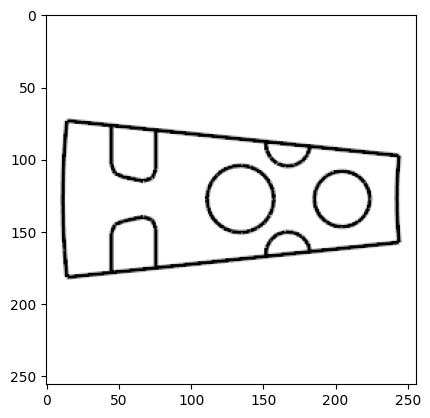

In [11]:
img=imread(os.path.join(y_train_folder_path,y_elements[15]))
plt.imshow(img)

In [12]:
x.max(),x.min(),y.max(),y.min()

(1.0, -1.0, 1.0, -1.0)

In [13]:

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=True):
        super(EncoderBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.batch_norm = nn.BatchNorm2d(out_channels) if batch_norm else None
        self.leaky_relu = nn.LeakyReLU(0.2)

        # Initialize weights
        nn.init.normal_(self.conv.weight, mean=0.0, std=0.02)
        if self.conv.bias is not None:
            nn.init.constant_(self.conv.bias, 0.0)

    def forward(self, x):
        x = self.conv(x.float())
        if self.batch_norm is not None:
            x = self.batch_norm(x)
        x = self.leaky_relu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=True):
        super(DecoderBlock, self).__init__()
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(0.5) if dropout else None
        self.leaky_relu = nn.LeakyReLU(0.1)

        # Initialize weights
        nn.init.normal_(self.conv_transpose.weight, mean=0.0, std=0.02)
        if self.conv_transpose.bias is not None:
            nn.init.constant_(self.conv_transpose.bias, 0.0)

    def forward(self, x, skip_con):
        x = self.conv_transpose(x.float())
        x = self.batch_norm(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = torch.cat((x, skip_con.float()), dim=1)
        x = self.leaky_relu(x)
        return x

class GeneratorModel(nn.Module):
    def __init__(self, input_shape=(2,256,256)):
        super(GeneratorModel, self).__init__()
        self.e1 = EncoderBlock(input_shape[0], 64, batch_norm=False)
        self.e2 = EncoderBlock(64, 128)
        self.e3 = EncoderBlock(128, 256)
        self.e4 = EncoderBlock(256, 512)
        self.e5 = EncoderBlock(512, 512)
        self.e6 = EncoderBlock(512, 512)
        self.e7 = EncoderBlock(512, 512)

        self.b = nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1)
        # Initialize weights
        nn.init.normal_(self.b.weight, mean=0.0, std=0.02)
        if self.b.bias is not None:
            nn.init.constant_(self.b.bias, 0.0)

        self.b_relu = nn.ReLU()

        self.d1 = DecoderBlock(512, 512)
        self.d2 = DecoderBlock(1024, 512)  # 512 + 512 (skip connection)
        self.d3 = DecoderBlock(1024, 512)  # 512 + 512 (skip connection)
        self.d4 = DecoderBlock(1024, 512, dropout=False)  # 512 + 512 (skip connection)
        self.d5 = DecoderBlock(1024, 256, dropout=False)  # 512 + 256 (skip connection)
        self.d6 = DecoderBlock(512, 128, dropout=False)  # 256 + 128 (skip connection)
        self.d7 = DecoderBlock(256, 64, dropout=False)   # 128 + 64 (skip connection)

        self.output_layer = nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1)
        # Initialize weights
        nn.init.normal_(self.output_layer.weight, mean=0.0, std=0.02)
        if self.output_layer.bias is not None:
            nn.init.constant_(self.output_layer.bias, 0.0)
        
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.float()
        e1 = self.e1(x)
        e2 = self.e2(e1)
        e3 = self.e3(e2)
        e4 = self.e4(e3)
        e5 = self.e5(e4)
        e6 = self.e6(e5)
        e7 = self.e7(e6)

        b = self.b(e7)
        b = self.b_relu(b)

        d1 = self.d1(b, e7)
        d2 = self.d2(d1, e6)
        d3 = self.d3(d2, e5)
        d4 = self.d4(d3, e4)
        d5 = self.d5(d4, e3)
        d6 = self.d6(d5, e2)
        d7 = self.d7(d6, e1)

        output = self.output_layer(d7)
        #output = self.sigmoid(output)
        output = self.tanh(output)
        return output



# Binary Cross Entropy Loss with logits
loss = nn.BCEWithLogitsLoss()
#loss = nn.BCELoss()
# Generator Loss Function
# Generator Loss Function
def gen_loss(generated_output, g_output, target):
    lambda_ = 100
    print(generated_output.shape)
    # GAN Loss
    gan_loss = loss(generated_output, torch.ones_like(generated_output))

    # Convert target tensor to the same data type as the generated output
    target = target.type_as(generated_output)

    # L1 Loss
    l1_loss = torch.mean(torch.abs(target - g_output))

    # Total Generator Loss
    g_loss_total = gan_loss + (lambda_ * l1_loss)
    
    return g_loss_total




In [14]:
from torchsummary import summary

# Define the model
generator = GeneratorModel(input_shape=(2,256,256))

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


generator.to(device)

# Print the model summary
summary(generator, input_size=(2, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           2,112
         LeakyReLU-2         [-1, 64, 128, 128]               0
      EncoderBlock-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,200
       BatchNorm2d-5          [-1, 128, 64, 64]             256
         LeakyReLU-6          [-1, 128, 64, 64]               0
      EncoderBlock-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         524,544
       BatchNorm2d-9          [-1, 256, 32, 32]             512
        LeakyReLU-10          [-1, 256, 32, 32]               0
     EncoderBlock-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 512, 16, 16]       2,097,664
      BatchNorm2d-13          [-1, 512, 16, 16]           1,024
        LeakyReLU-14          [-1, 512,

In [162]:
class DiscriminatorModel(nn.Module):
    def __init__(self, input_shape=(3, 256, 256)):
        super(DiscriminatorModel, self).__init__()
        self.init_weights = nn.init.normal_

        self.conv1 = nn.Conv2d(input_shape[0], 64, kernel_size=4, stride=2, padding=1)
        self.lrelu1 = nn.LeakyReLU(0.2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.lrelu2 = nn.LeakyReLU(0.2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.lrelu3 = nn.LeakyReLU(0.2)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(512)
        self.lrelu4 = nn.LeakyReLU(0.2)

        self.conv5 = nn.Conv2d(512, 1, kernel_size=4, padding=1)

        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                self.init_weights(m.weight, mean=0.0, std=0.02)
                if m.bias is not None:
                    m.bias.data = m.bias.data.float()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data = m.weight.data.float()
                m.bias.data = m.bias.data.float()

    def forward(self, x):
        x = x.float()
        x = self.conv1(x)
        x = self.lrelu1(x)

        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.lrelu2(x)

        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.lrelu3(x)

        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = self.lrelu4(x)

        x = self.conv5(x)
        return x


In [163]:
discriminator = DiscriminatorModel(input_shape=(3,256,256))
#discriminator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
discriminator.to(device)
# Print the model summary
summary(discriminator, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,664
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12            [-1, 1, 15, 15]           8,193
Total params: 2,766,529
Trainable params: 2,766,529
Non-trainable params: 0
---------------------------

In [164]:

def disc_loss(real_output, fake_output):
    real_loss = F.binary_cross_entropy_with_logits(real_output, torch.ones_like(real_output))
    fake_loss = F.binary_cross_entropy_with_logits(fake_output, torch.zeros_like(fake_output))
    return real_loss + fake_loss



In [165]:
import torch.optim as optim

# Generator optimizer
gen_opt = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Discriminator optimizer
disc_opt = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


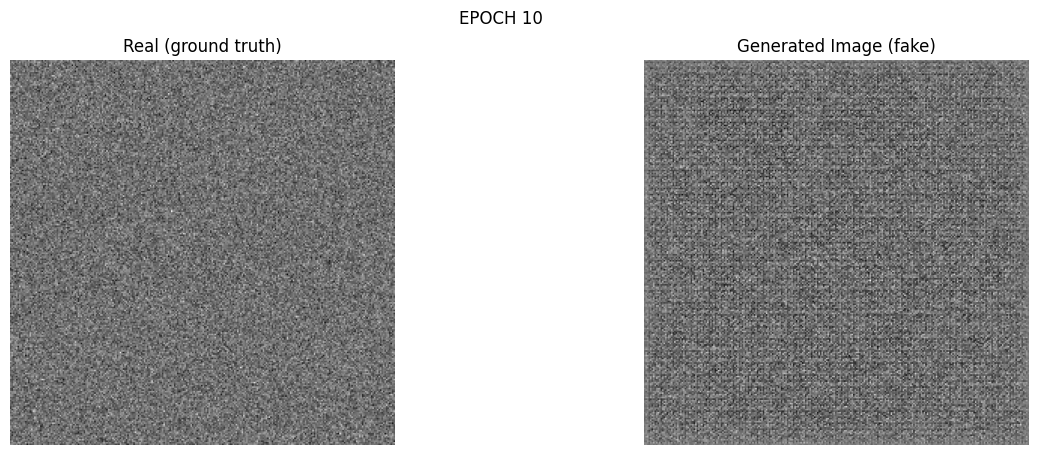

In [177]:
def compare_images(input_test, target, epoch):
    
    #generator.eval()  # Set generator to evaluation mode
    with torch.no_grad():
        input_test = input_test.to(device)  # Move input tensor to the same device as the model
        target = target.to(device)  # Move target tensor to the same device as the model

        generated = generator(input_test)
    print(target[0].shape, generated[0].shape)

    plt.figure(figsize=(15, 5))

    images_list = [target[0].numpy(), generated[0].numpy()]  # Move tensors back to CPU for plotting
    title = ['Real (ground truth)', 'Generated Image (fake)']

    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(title[i])
        plt.imshow(np.reshape(images_list[i],(256,256,1)),cmap='gray')
        #plt.imshow(images_list[i].transpose(1, 2, 0) * 0.5 + 0.5, cmap='gray')
        plt.axis('off')

    plt.suptitle(f'EPOCH {epoch}')
    plt.show()

# Example usage
input_test = torch.randn(1, 2, 256, 256).to(device)  # Example input tensor with shape [batch_size, channels, height, width]
target = torch.randn(1, 1, 256, 256).to(device)  # Example target tensor with shape [batch_size, channels, height, width]
epoch = 10  # Example epoch number
compare_images(input_test, target, epoch)


In [18]:

from torchvision.utils import save_image
def save_some_examples(gen, train_loader, epoch, folder):
    x, y = next(iter(train_loader))
    x, y = x.to(device), y.to(device)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()

In [19]:

x_np = x[0:100]
y_np = y[0:100]

# Convert NumPy arrays to PyTorch tensors
x_tensor = torch.tensor(x_np)
y_tensor = torch.tensor(y_np)

# Create a PyTorch dataset
dataset = TensorDataset(x_tensor, y_tensor) 


train_loader = DataLoader(
        dataset,
        batch_size=1)
       

In [180]:
def train_fn(disc, gen, loader, opt_disc, opt_gen, g_scaler, d_scaler,l1_loss,bce,L1_LAMBDA=100):
    loop = tqdm(loader, leave=True)
    t = iter(loader)
    (X,Y) = next(t)
    for idx, (x, y) in enumerate(loop):
        x = x.to(device)
        y = y.to(device)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(torch.cat([x, y], dim=1))
            D_real_loss = ss = bce(D_real, torch.ones_like(D_real))
            #D_fake = disc(x, y_fake.detach())
            D_fake = disc(torch.cat([x, y_fake.detach()], dim=1))
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2
            
            #D_loss = disc_loss(D_real, D_fake)

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(torch.cat([x, y_fake], dim=1))
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1
            #G_loss = gen_loss(D_fake, y_fake, y)

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            compare_images(X, Y, 0)
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


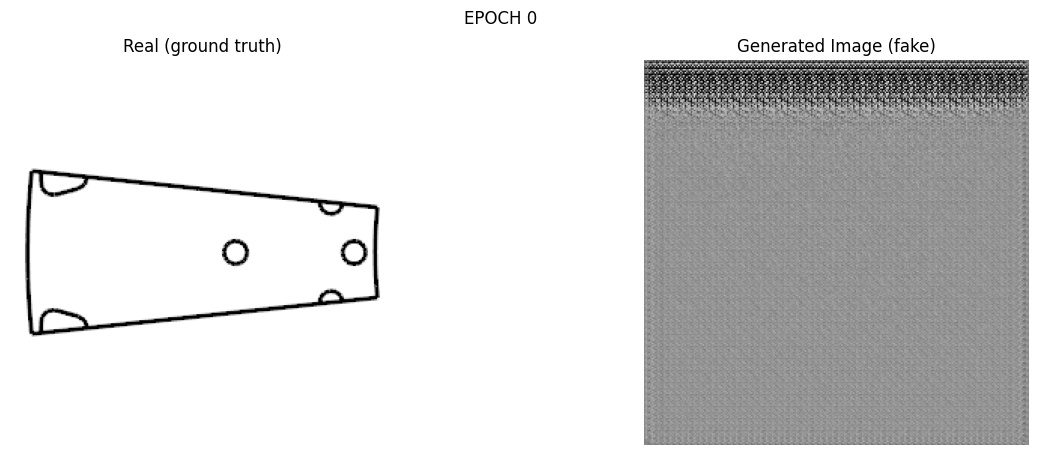

 10%|█████▎                                               | 10/100 [00:09<01:22,  1.10it/s, D_fake=0.255, D_real=0.755]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


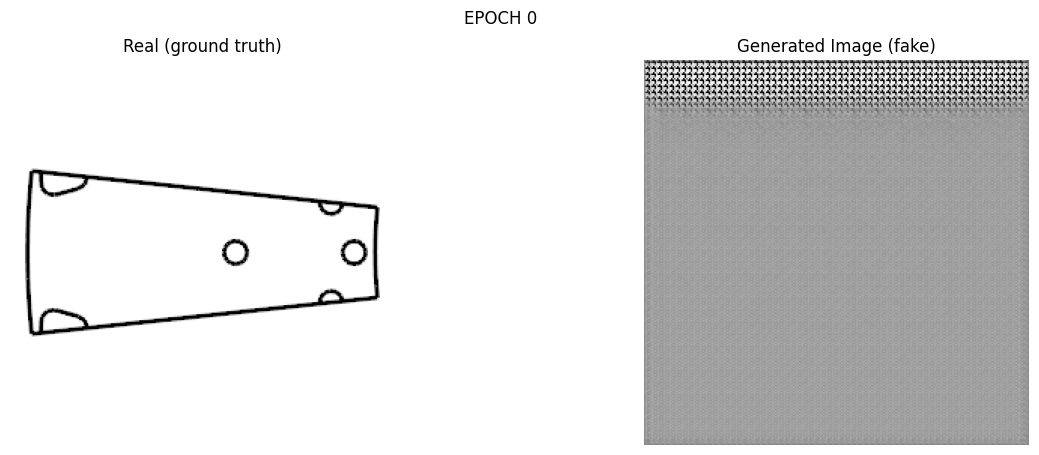

 20%|██████████▊                                           | 20/100 [00:19<01:12,  1.10it/s, D_fake=0.15, D_real=0.801]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


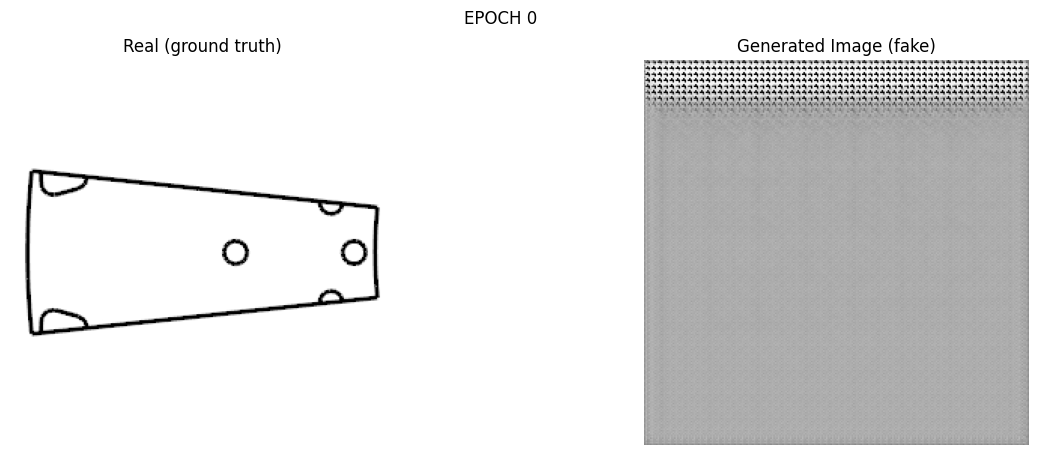

 30%|███████████████▌                                    | 30/100 [00:28<01:03,  1.10it/s, D_fake=0.0561, D_real=0.915]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


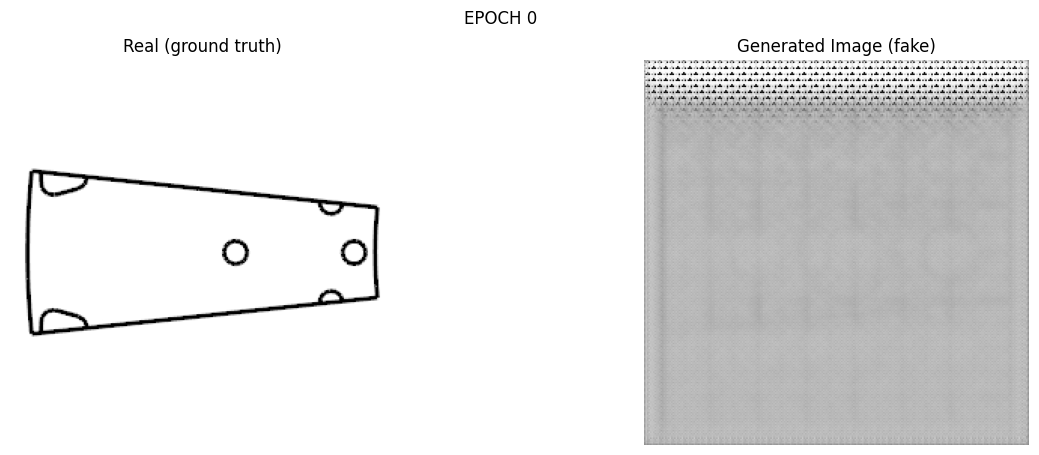

 40%|████████████████████▊                               | 40/100 [00:37<00:54,  1.11it/s, D_fake=0.0317, D_real=0.956]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


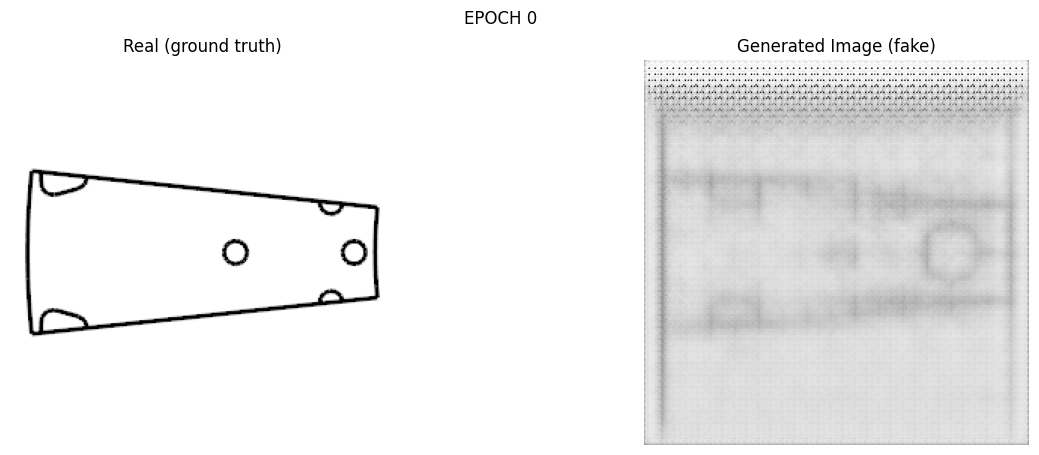

 50%|██████████████████████████                          | 50/100 [00:47<00:45,  1.10it/s, D_fake=0.0336, D_real=0.956]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


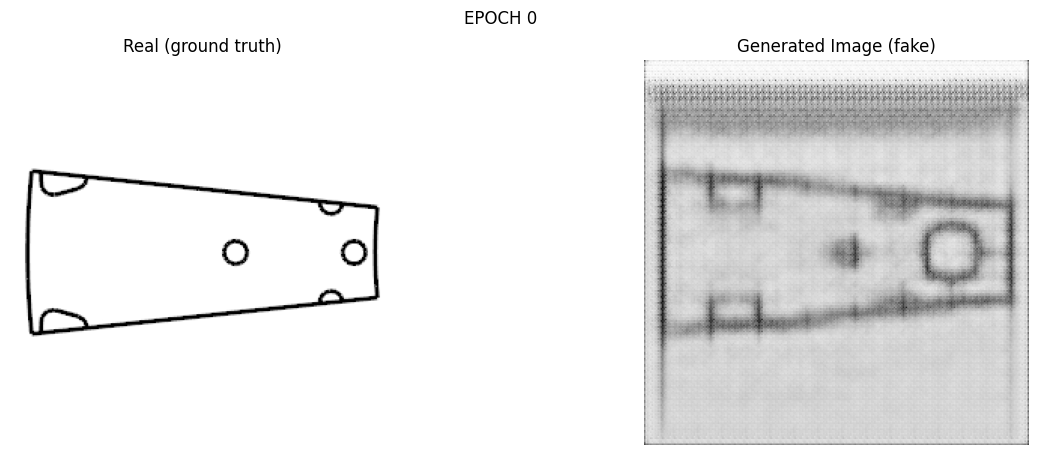

 60%|███████████████████████████████▊                     | 60/100 [00:56<00:35,  1.12it/s, D_fake=0.238, D_real=0.657]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


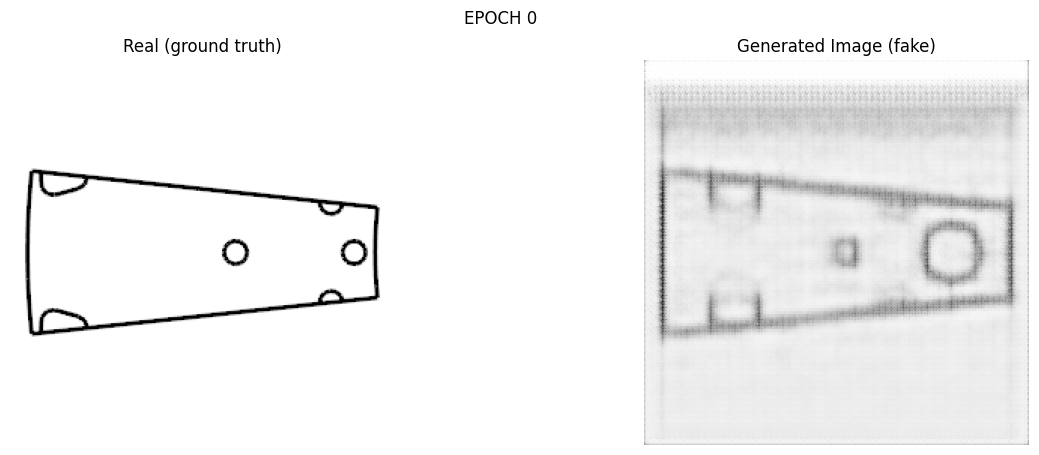

 70%|█████████████████████████████████████                | 70/100 [01:05<00:26,  1.15it/s, D_fake=0.252, D_real=0.617]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


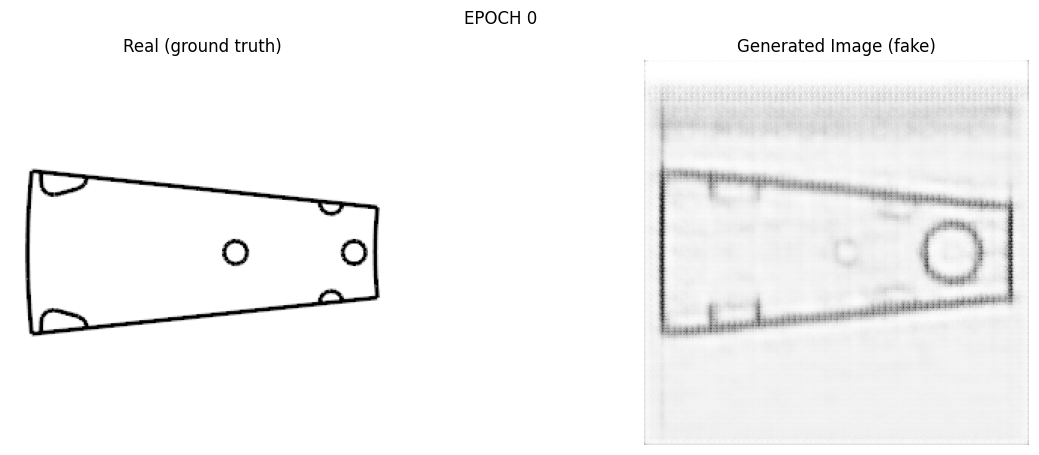

 80%|███████████████████████████████████████████▏          | 80/100 [01:15<00:17,  1.11it/s, D_fake=0.21, D_real=0.672]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


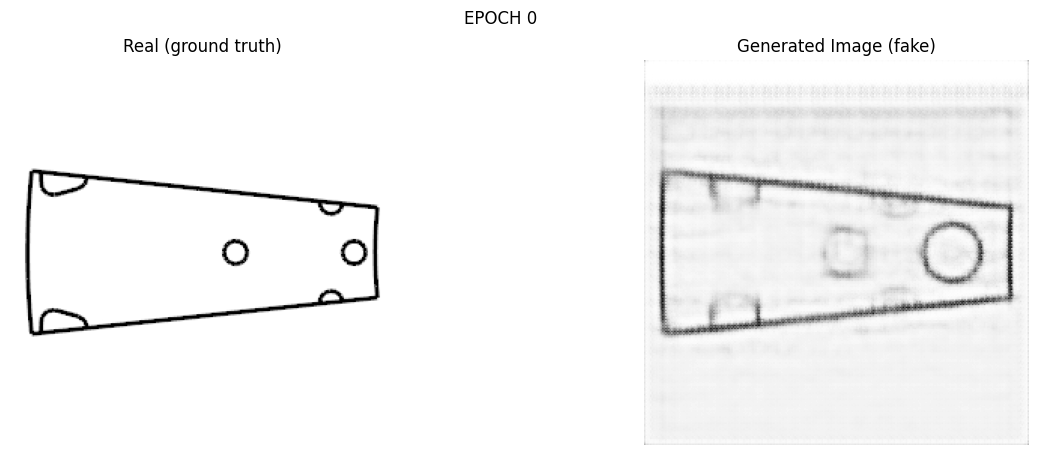

 90%|██████████████████████████████████████████████▊     | 90/100 [01:24<00:08,  1.13it/s, D_fake=0.0968, D_real=0.845]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


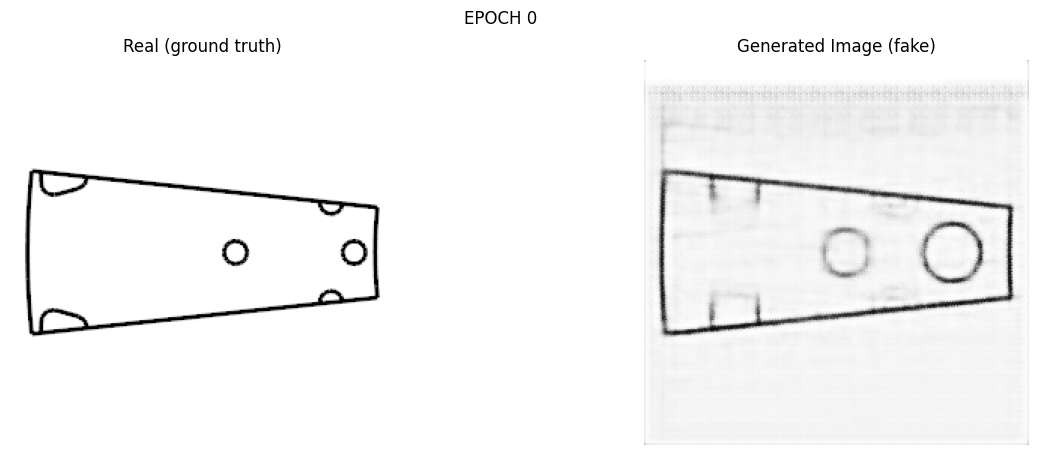

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


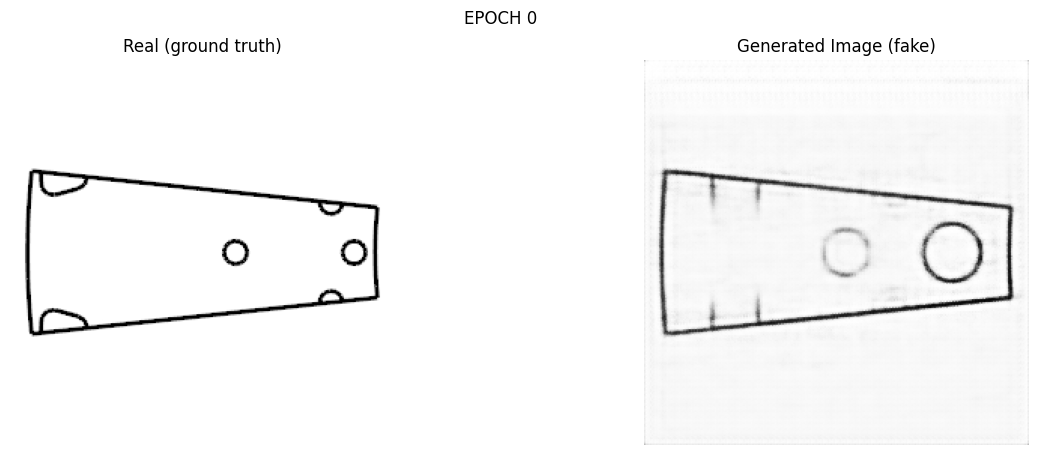

 10%|█████▎                                               | 10/100 [00:09<01:22,  1.10it/s, D_fake=0.104, D_real=0.817]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


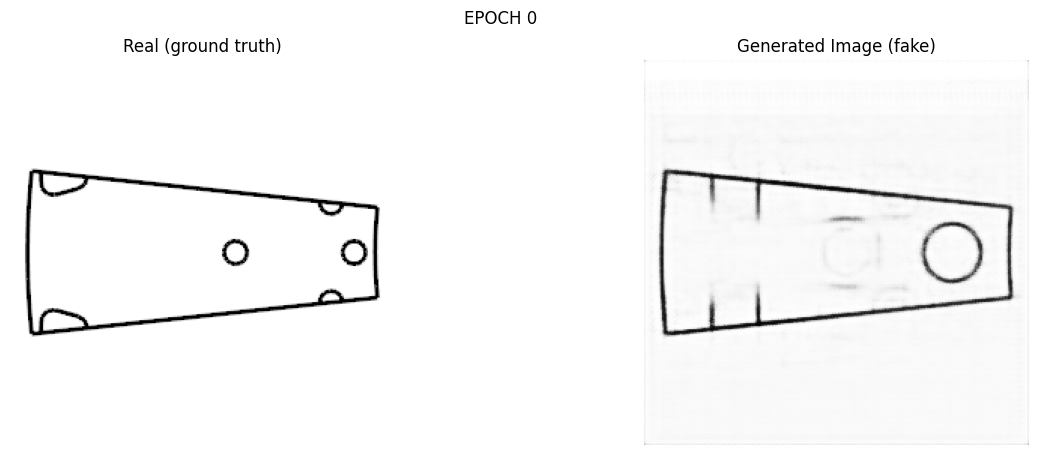

 20%|██████████▌                                          | 20/100 [00:18<01:09,  1.15it/s, D_fake=0.208, D_real=0.804]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


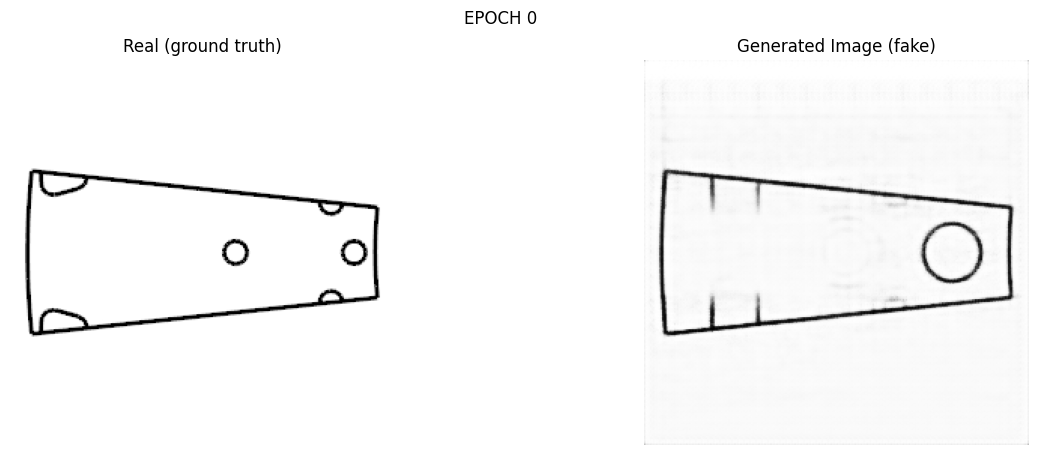

 30%|███████████████▉                                     | 30/100 [00:27<01:03,  1.11it/s, D_fake=0.511, D_real=0.383]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


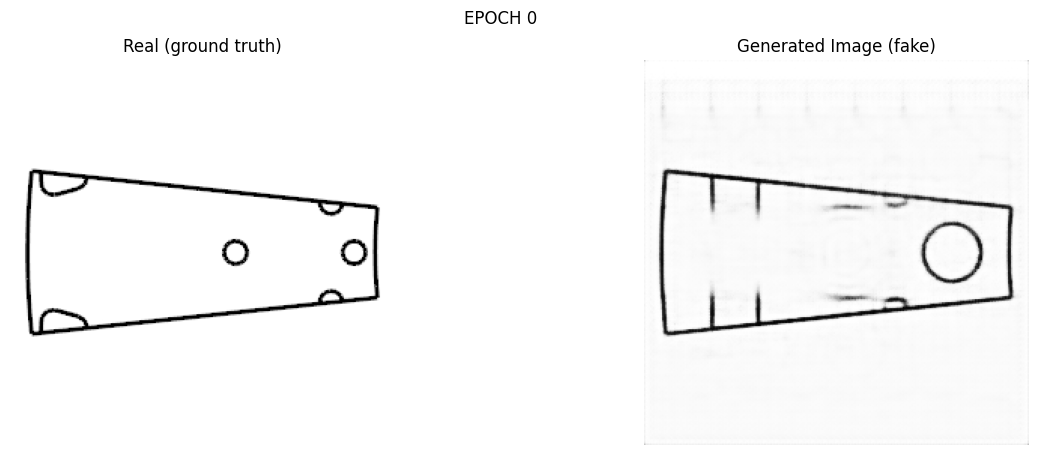

 40%|█████████████████████▌                                | 40/100 [00:36<00:53,  1.12it/s, D_fake=0.14, D_real=0.827]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


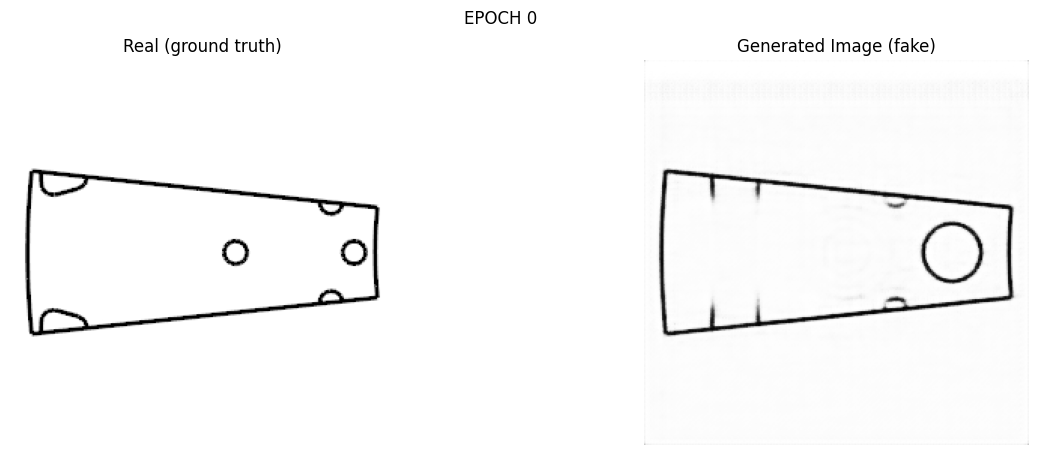

 50%|██████████████████████████▌                          | 50/100 [00:45<00:43,  1.15it/s, D_fake=0.346, D_real=0.594]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


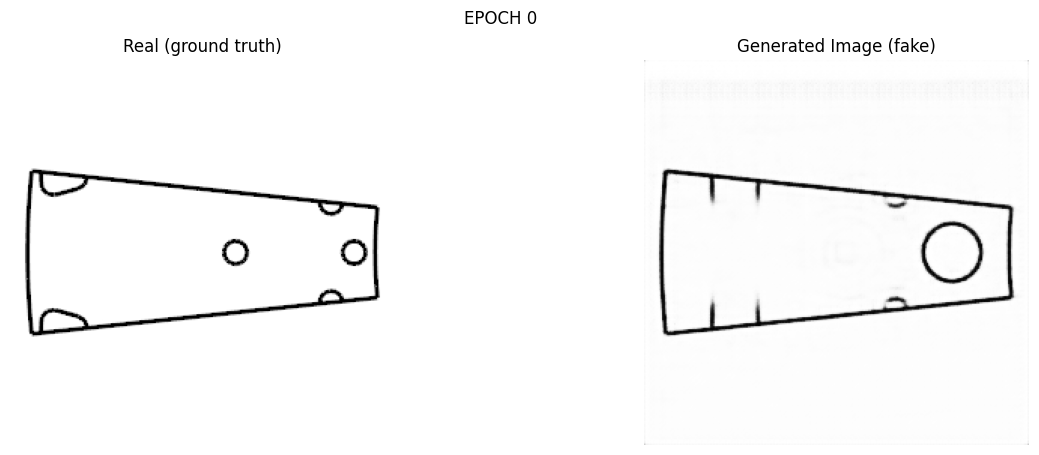

 60%|███████████████████████████████▊                     | 60/100 [00:54<00:34,  1.16it/s, D_fake=0.406, D_real=0.525]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


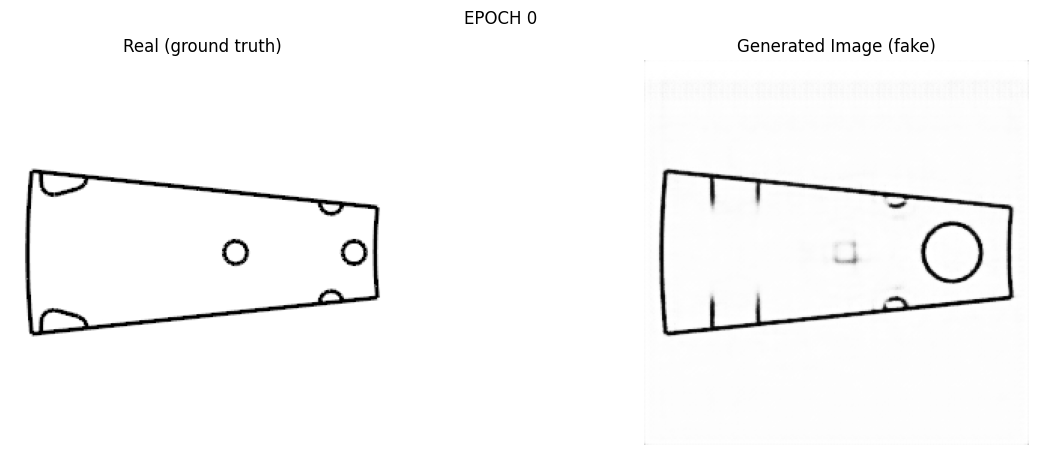

 70%|█████████████████████████████████████                | 70/100 [01:04<00:27,  1.10it/s, D_fake=0.109, D_real=0.855]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


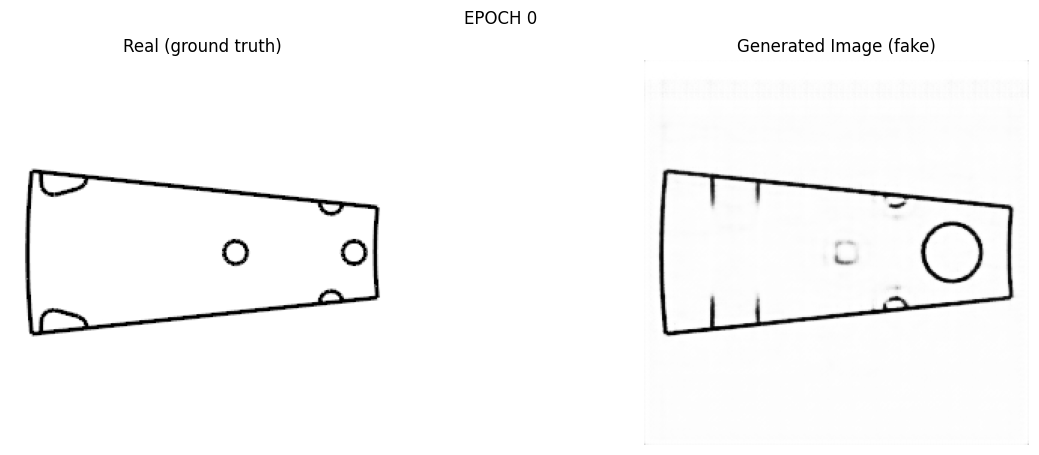

 80%|██████████████████████████████████████████▍          | 80/100 [01:13<00:17,  1.15it/s, D_fake=0.332, D_real=0.692]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


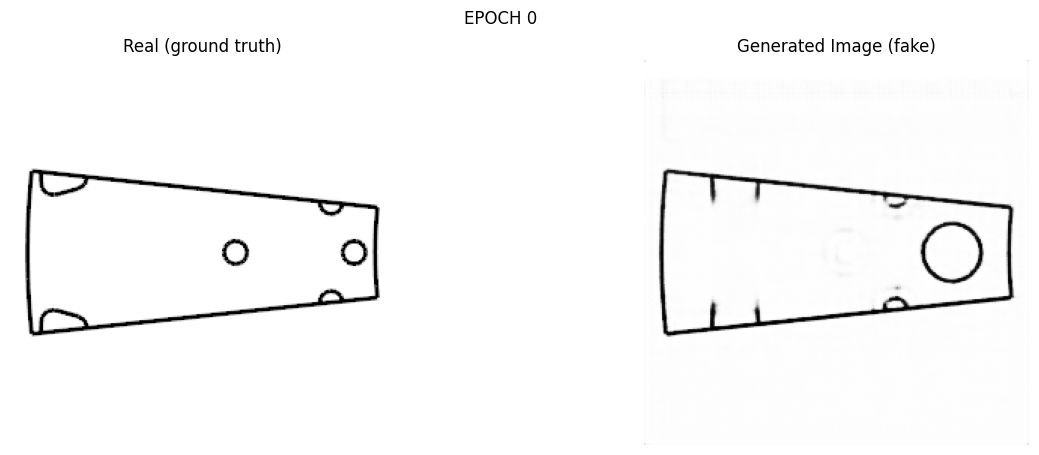

 90%|███████████████████████████████████████████████▋     | 90/100 [01:22<00:08,  1.15it/s, D_fake=0.262, D_real=0.724]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


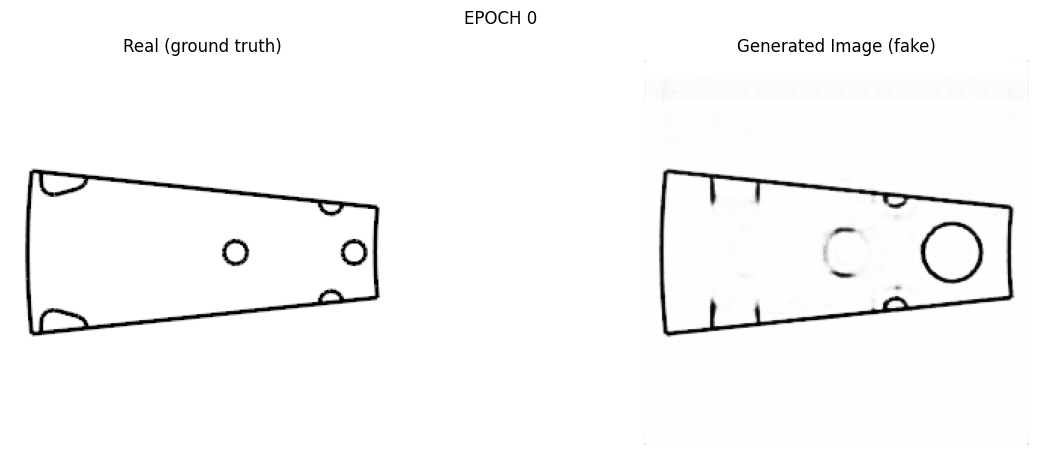

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


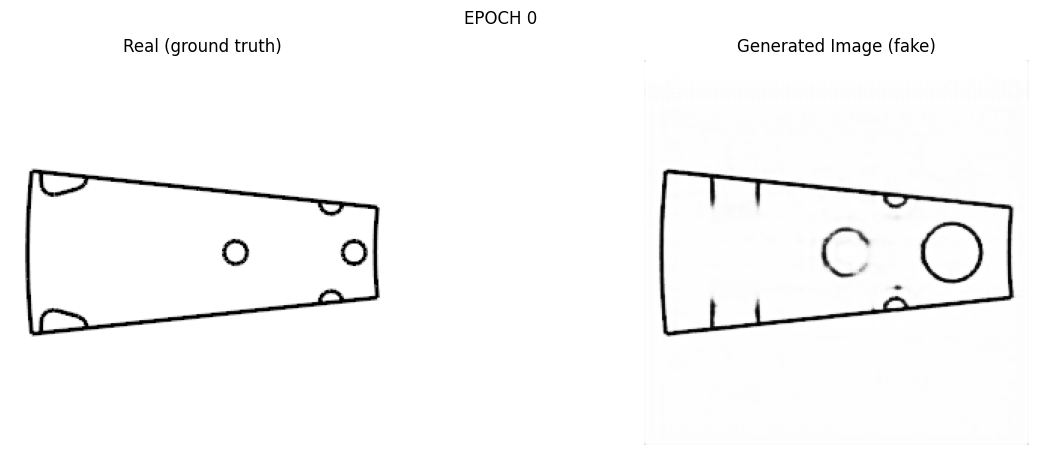

 10%|█████▎                                               | 10/100 [00:09<01:18,  1.15it/s, D_fake=0.214, D_real=0.669]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


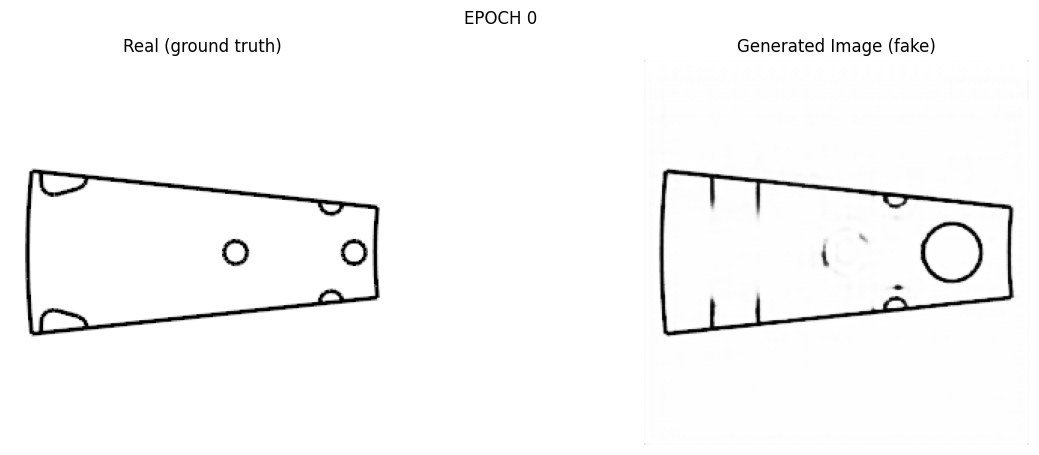

 20%|██████████▌                                          | 20/100 [00:17<01:08,  1.16it/s, D_fake=0.424, D_real=0.385]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


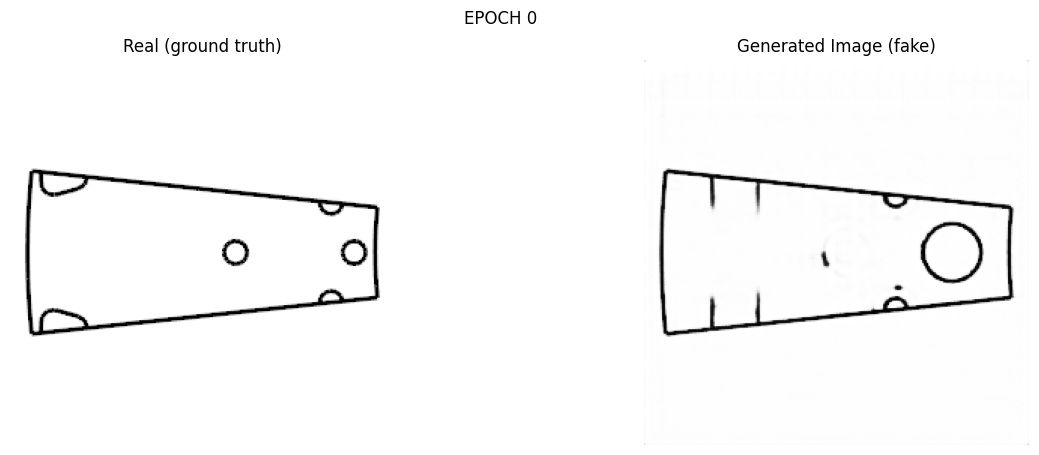

 30%|███████████████▉                                     | 30/100 [00:27<01:05,  1.07it/s, D_fake=0.665, D_real=0.453]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


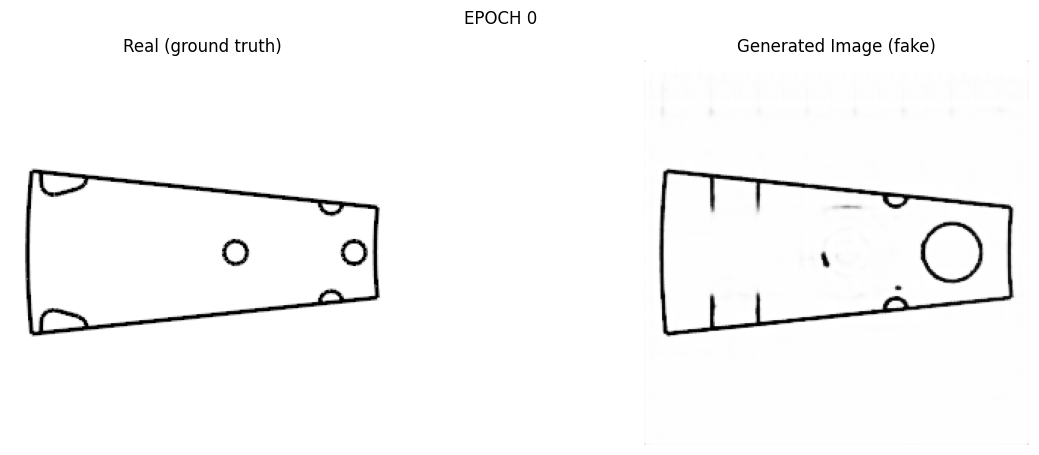

 40%|█████████████████████▏                               | 40/100 [00:37<00:56,  1.07it/s, D_fake=0.239, D_real=0.752]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


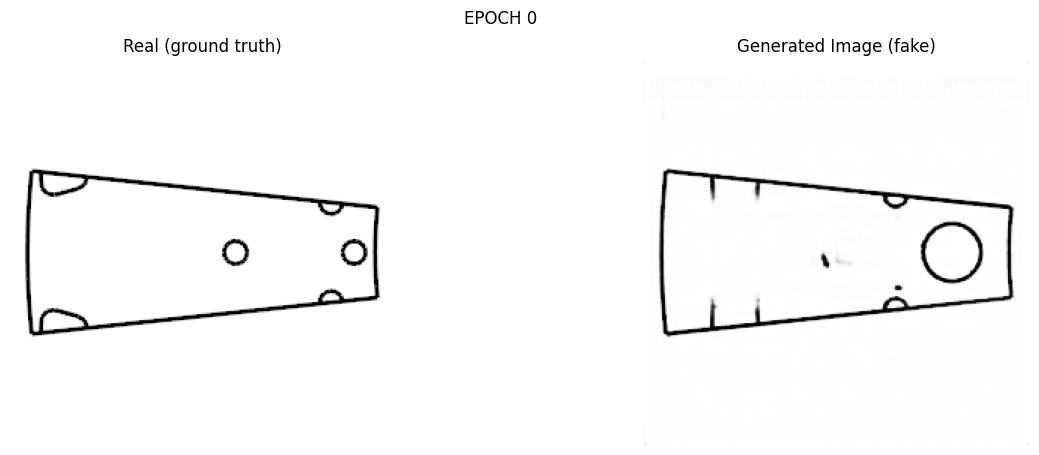

 50%|██████████████████████████▌                          | 50/100 [00:46<00:44,  1.11it/s, D_fake=0.293, D_real=0.696]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


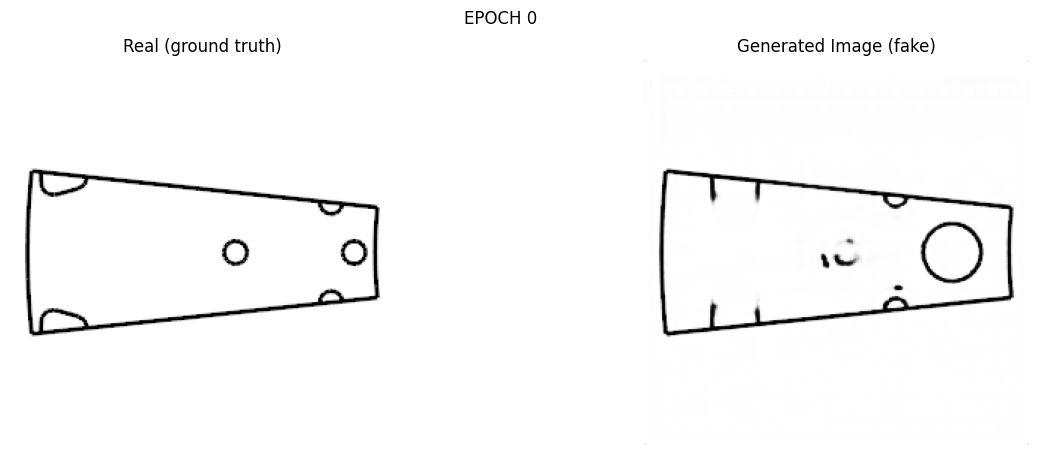

 60%|███████████████████████████████▊                     | 60/100 [00:55<00:34,  1.15it/s, D_fake=0.263, D_real=0.722]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


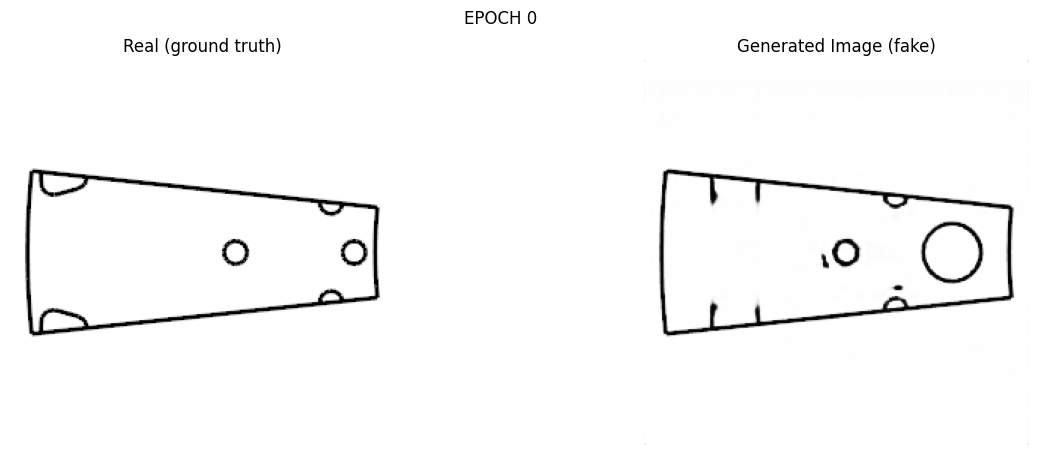

 70%|█████████████████████████████████████                | 70/100 [01:04<00:26,  1.14it/s, D_fake=0.369, D_real=0.378]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


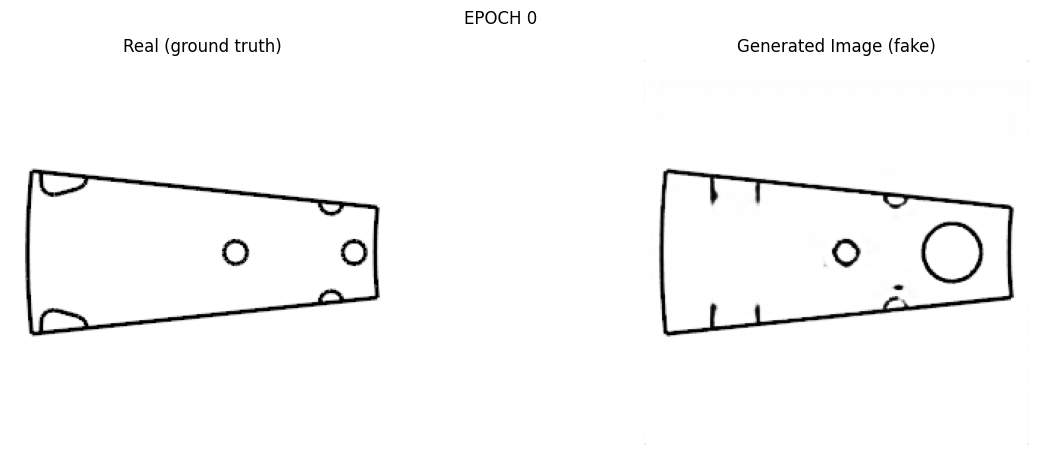

 80%|██████████████████████████████████████████▍          | 80/100 [01:13<00:17,  1.14it/s, D_fake=0.298, D_real=0.712]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


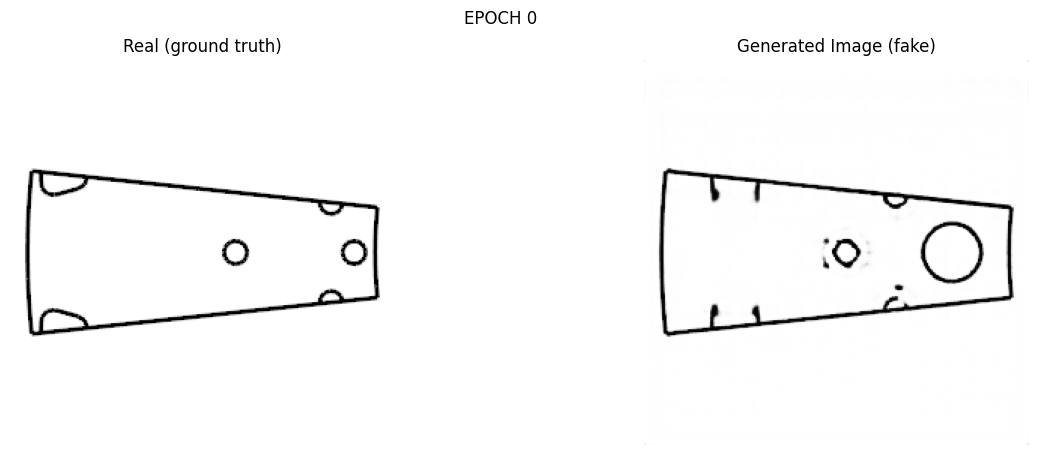

 90%|███████████████████████████████████████████████▋     | 90/100 [01:23<00:09,  1.09it/s, D_fake=0.297, D_real=0.667]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


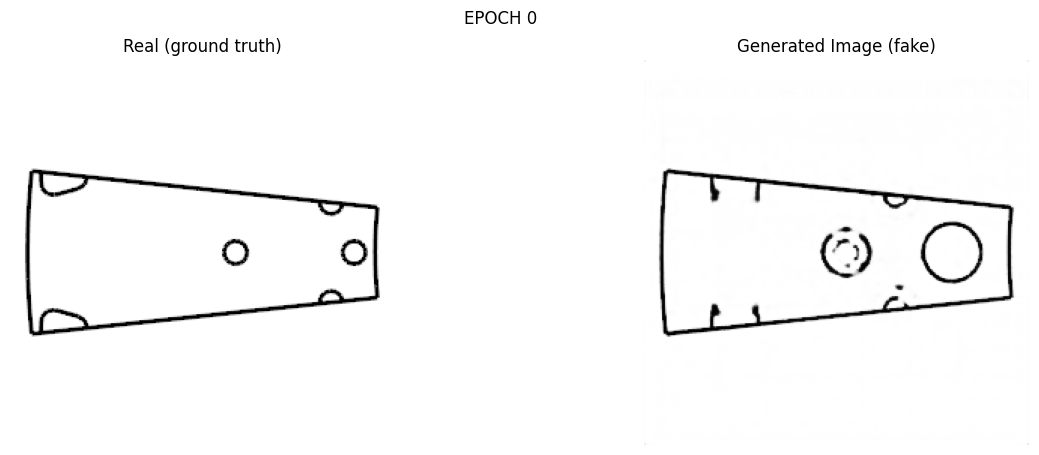

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


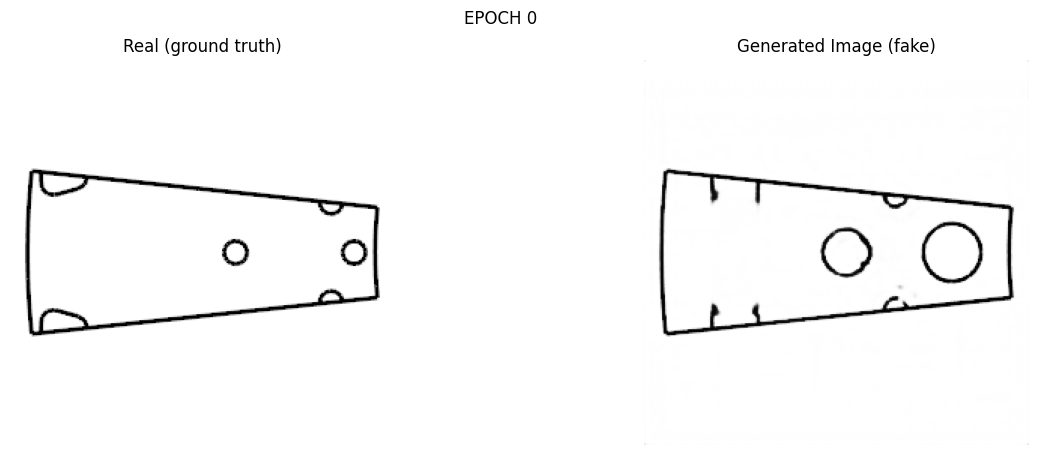

 10%|█████▎                                               | 10/100 [00:09<01:22,  1.08it/s, D_fake=0.644, D_real=0.277]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


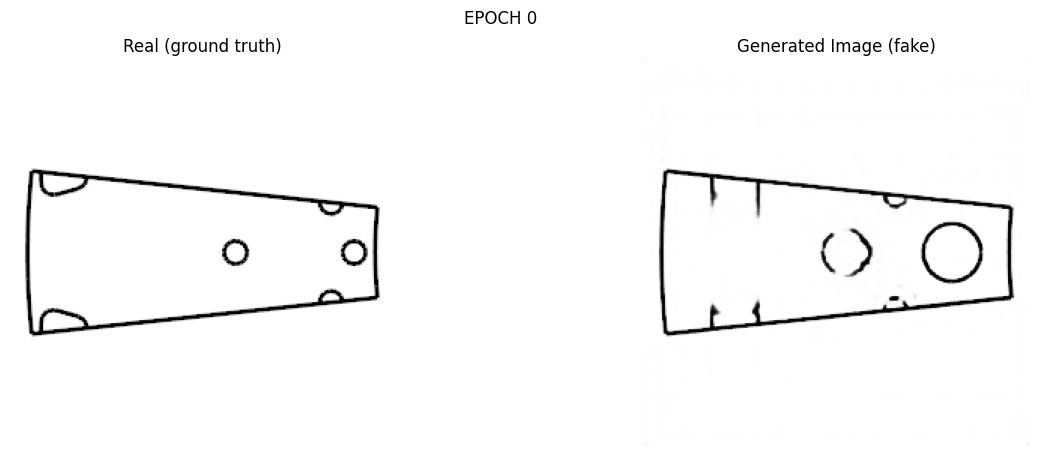

 20%|██████████▌                                          | 20/100 [00:18<01:09,  1.14it/s, D_fake=0.291, D_real=0.702]

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


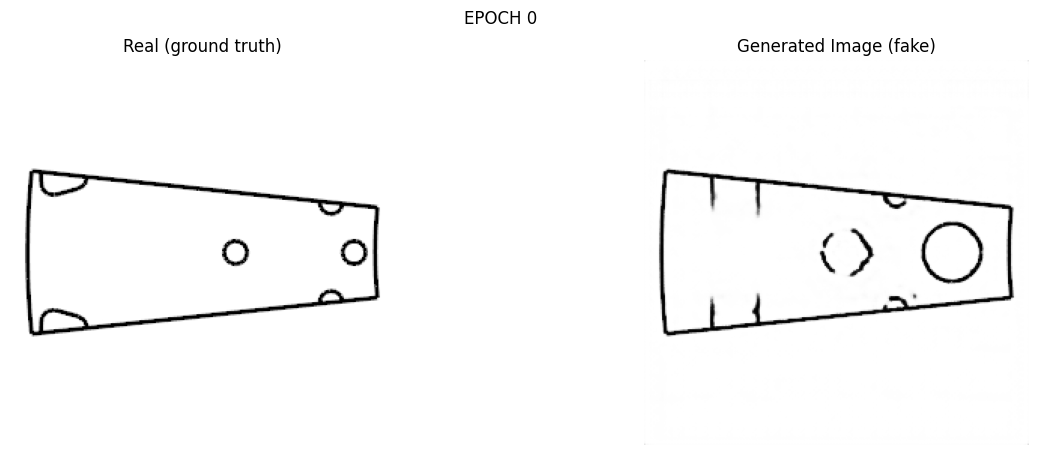

 29%|███████████████▎                                     | 29/100 [00:27<01:07,  1.06it/s, D_fake=0.278, D_real=0.715]


KeyboardInterrupt: 

In [181]:
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

NUM_EPOCHS=100
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()
    
    
for epoch in range(NUM_EPOCHS):
      
    train_fn(discriminator, generator, train_loader, disc_opt, gen_opt, g_scaler, d_scaler,L1_LOSS,BCE)
    
    save_some_examples(generator, train_loader, epoch, folder="evaluation")


In [ ]:
t =iter(train_loader)
x,y = next(t)

In [ ]:
plt.imshow(y[0].reshape(256,256,1))

In [ ]:
# Save the model
torch.save(generator.state_dict(), 'p2p_gen_torch.pth')



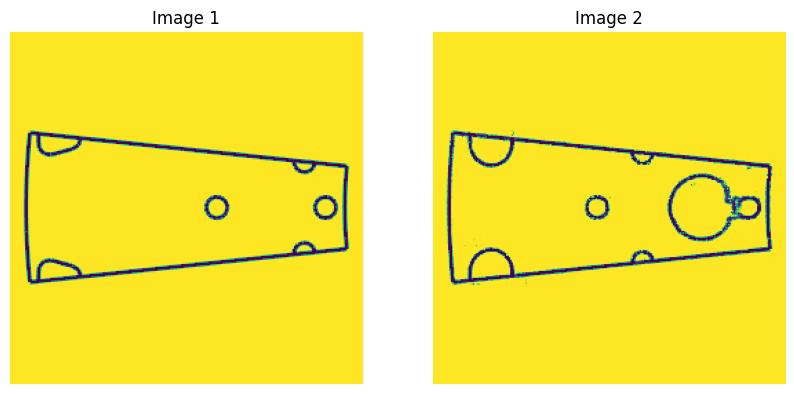

IndexError: index 1 is out of bounds for dimension 0 with size 1

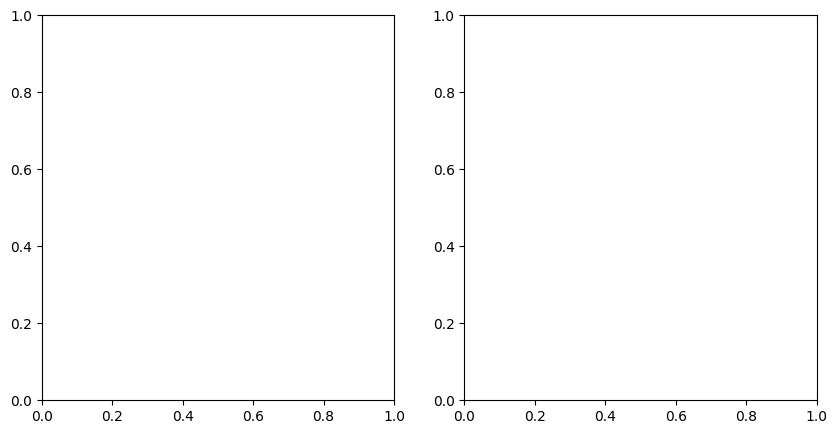

In [33]:
#MODEL TESTING

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the transform to normalize the data
'''
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images if needed
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to [-1, 1]
])
'''



# Load the model
model = GeneratorModel(input_shape=(2,256,256))
model.load_state_dict(torch.load('p2p_gen_torch.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

# Get a batch of test images and labels
test_images, test_labels = next(iter(train_loader))

# Make predictions
with torch.no_grad():  # No need to compute gradients for evaluation
    predicted = model(test_images)

predicted = predicted.permute(0, 2, 3, 1)
test_labels = test_labels.permute(0, 2, 3, 1)
#plt.imshow(test_labels[0])


# Helper function to unnormalize and convert tensor to numpy array
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



for i in range(10):
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    # Plot the first image
    axs[0].imshow(test_labels[i])
    axs[0].set_title('Image 1')
    axs[0].axis('off')  # Hide the axes

    # Plot the second image
    axs[1].imshow(predicted[i])
    axs[1].set_title('Image 2')
    axs[1].axis('off')  # Hide the axes

    # Display the plot
    plt.show()

plt.show()




In [ ]:
x_tr=x[1200:1220]
y_tr=y[1200:1220]
from IPython import display
for i in range(20):
    display.display(display.HTML(f'<h3>Test Input {i+1}</h3>'))
    plt.figure(figsize=(15,5))
    plt.subplot(1,4,1)
    plt.imshow(x_tr[i,:,:,0],cmap='gray')
    plt.axis(False)
    plt.title('Temp')
    
    plt.subplot(1,4,2)
    plt.imshow(x_tr[i,:,:,1],cmap='gray')
    plt.axis(False)
    plt.title('Disp')
    
    plt.subplot(1,4,3)
    res=generator(tf.expand_dims(x_tr[i],axis=0))
    plt.imshow(res[0],cmap='gray')
    plt.axis(False)
    plt.title('Generated')
    
    plt.subplot(1,4,4)
    plt.imshow(y_tr[i],cmap='gray')
    plt.axis(False)
    plt.title('Ground Truth')
    plt.savefig(f'comparison_plot_1200_img_batch_size_64_img{i+1}.png')
    plt.show()

In [ ]:
res=generator(tf.expand_dims(x[1499],axis=0))
plt.imshow(res[0],cmap='gray')